## Fine Tune a Vision Transformer for Age Prediction

We want to fine tune a pre-trained vision transformer for the task of face age prediction, using the UTKFace dataset. 



### Set up environment

Make sure required libraries are installed and loaded.

In [7]:
!pip install torch torchvision
!pip install transformers datasets
!pip install transformers[torch]
!pip install scikit-image

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 432.1 kB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.5/313.5 kB 975.1 kB/s eta 0:00:000:01:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 1.5 MB/s eta 0:00:0000:0100:01


In [1]:
# PyTorch
import torch
import torchvision
from torchvision.transforms import Normalize, Resize, ToTensor, Compose
# For dislaying images
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage
import skimage
# Loading dataset
from datasets import load_dataset, Dataset, Image, ClassLabel
# Transformers
from transformers import ViTImageProcessor, ViTForImageClassification
from transformers import TrainingArguments, Trainer
# Matrix operations
import numpy as np
# Evaluation
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Utilities
import os

### Dataset Preparation

We are working with the UTKFace dataset, which has been downloaded from Kaggle. We need to load it into a Transformers labelled dataset format, using the file names to extract the age labels. Then we split it into a training and testing split. 



In [56]:
age_range=5

img_dir = "utkface_aligned_cropped/UTKFace"
img_ages = [fname.split("_")[0] for fname in os.listdir(img_dir)]
img_ranks_labels = [(int(int(a)/age_range),str(int(int(a)/age_range)*age_range)+"-"+str((int(int(a)/age_range + 1))*age_range)) for a in img_ages] 
img_labels = [l for (k,l) in img_ranks_labels]

unique_ranks_labels = sorted(list(set(img_ranks_labels)))
unique_labels = [l for (k,l) in unique_ranks_labels]

unique_labels

['0-5',
 '5-10',
 '10-15',
 '15-20',
 '20-25',
 '25-30',
 '30-35',
 '35-40',
 '40-45',
 '45-50',
 '50-55',
 '55-60',
 '60-65',
 '65-70',
 '70-75',
 '75-80',
 '80-85',
 '85-90',
 '90-95',
 '95-100',
 '100-105',
 '105-110',
 '110-115',
 '115-120']

In [57]:
ClassLabels = ClassLabel(num_classes=len(unique_labels), names=unique_labels)

dataset = Dataset.from_dict({"image": [img_dir+"/"+fname for fname in os.listdir(img_dir)],"label":img_labels}).cast_column("image", Image()).cast_column("label",ClassLabels)

Casting the dataset:   0%|          | 0/23708 [00:00<?, ? examples/s]

In [58]:
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 23708
})

In [59]:
ClassLabels.names[dataset[2]["label"]]

'85-90'

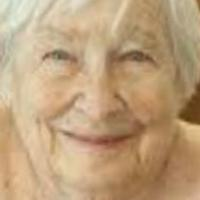

In [60]:
dataset[2]["image"]

In [61]:
splits = dataset.train_test_split(test_size=0.1)
trainds = splits['train']
testds = splits['test']
splits2 = testds.train_test_split(test_size=0.2)
testds = splits2['train']
valds = splits2['test']
trainds, testds, valds

(Dataset({
     features: ['image', 'label'],
     num_rows: 21337
 }),
 Dataset({
     features: ['image', 'label'],
     num_rows: 1896
 }),
 Dataset({
     features: ['image', 'label'],
     num_rows: 475
 }))

In [62]:
itos = dict((k,v) for k,v in enumerate(trainds.features['label'].names))
stoi = dict((v,k) for k,v in enumerate(trainds.features['label'].names))
#itos

50-55


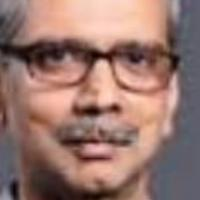

In [63]:
index = 6
img, lab = trainds[index]['image'], itos[trainds[index]['label']]
print(lab)
img

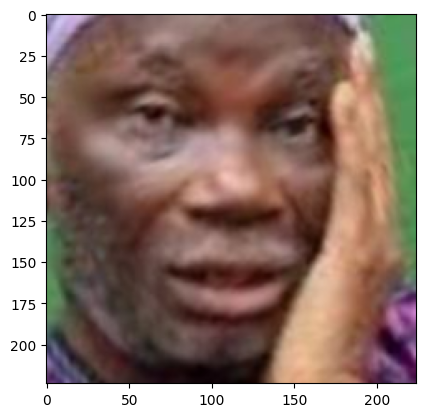

In [65]:
model_name = "google/vit-base-patch16-224"
processor = ViTImageProcessor.from_pretrained(model_name) 

mu, sigma = processor.image_mean, processor.image_std #get default mu,sigma
size = processor.size

norm = Normalize(mean=mu, std=sigma) #normalize image pixels range to [-1,1]

# resize 3x32x32 to 3x224x224 -> convert to Pytorch tensor -> normalize
_transf = Compose([
    Resize(size['height']),
    ToTensor(),
    norm
]) 

# apply transforms to PIL Image and store it to 'pixels' key
def transf(arg):
    arg['pixels'] = [_transf(image.convert('RGB')) for image in arg['image']]
    return arg


trainds.set_transform(transf)
valds.set_transform(transf)
testds.set_transform(transf)

idx = 0
ex = trainds[idx]['pixels']
ex = (ex+1)/2 #imshow requires image pixels to be in the range [0,1]
exi = ToPILImage()(ex)
plt.imshow(exi)
plt.show()

In [66]:
model_name = "google/vit-base-patch16-224"
model = ViTForImageClassification.from_pretrained(model_name)
print(model.classifier)


Linear(in_features=768, out_features=1000, bias=True)


### Creating a custom model

Here, we redefine the classification task of the model from the pre-training (image classification in 1000 labels) to the fine-tuning task (age classification)

In [67]:
model = ViTForImageClassification.from_pretrained(model_name, num_labels=len(unique_labels), ignore_mismatched_sizes=True, id2label=itos, label2id=stoi)
print(model.classifier)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([24]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([24, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Linear(in_features=768, out_features=24, bias=True)


In [68]:
args = TrainingArguments(
    f"test-face-age",
    save_strategy="epoch",
    eval_strategy="epoch",
    learning_rate=2e-5,
    num_train_epochs=3,
    #weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    logging_dir='logs',
    remove_unused_columns=False,
)

def collate_fn(examples):
    pixels = torch.stack([example["pixels"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixels, "labels": labels}

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return dict(accuracy=accuracy_score(predictions, labels))

trainer = Trainer(
    model,
    args, 
    train_dataset=trainds,
    eval_dataset=valds,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=processor,
)



In [69]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,1.509000,1.479095,0.444211
2,1.294700,1.493765,0.435789
3,1.055800,1.509429,0.448421


TrainOutput(global_step=8004, training_loss=1.3340453368791754, metrics={'train_runtime': 2422.4956, 'train_samples_per_second': 26.424, 'train_steps_per_second': 3.304, 'total_flos': 4.961317822255743e+18, 'train_loss': 1.3340453368791754, 'epoch': 3.0})

In [76]:
trainer.save_model("owntrained-vit-faceage")

In [70]:
outputs = trainer.predict(testds)
print(outputs.metrics)

{'test_loss': 1.4848542213439941, 'test_accuracy': 0.4440928270042194, 'test_runtime': 19.3968, 'test_samples_per_second': 97.748, 'test_steps_per_second': 12.219}


In [71]:
itos[np.argmax(outputs.predictions[0])], itos[outputs.label_ids[0]]

('0-5', '0-5')

In [72]:
y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

used_labels = [f for (i,f) in enumerate(trainds.features['label'].names) if i in y_true]


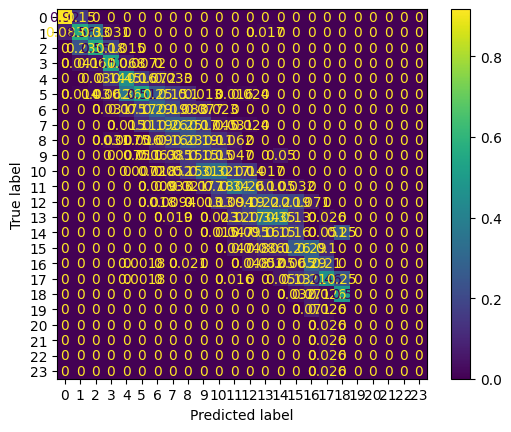

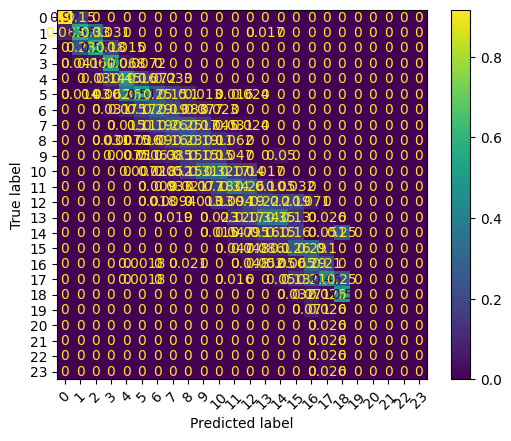

In [79]:
#labels = itos[]#trainds.features['label'].names
#cm = confusion_matrix(y_true, y_pred)
#disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=used_labels,normalize='true')
disp = ConfusionMatrixDisplay.from_predictions(y_true,y_pred,normalize='pred')
disp.plot(xticks_rotation=45)
#disp.plot()

In [74]:
for i in range(10): 
    print(itos[np.argmax(outputs.predictions[i])], itos[outputs.label_ids[i]])

0-5 0-5
20-25 25-30
25-30 25-30
50-55 50-55
75-80 70-75
35-40 30-35
65-70 65-70
25-30 25-30
70-75 60-65
15-20 15-20


### How to run prediction with the trained model on a new image? 

We need to load our test images and predict on them (never-seen). And on an image loaded from the file server. 